In [ ]:
import warnings
import logging

warnings.filterwarnings("ignore", category=DeprecationWarning, module="flwr")
logging.getLogger("flwr").setLevel(logging.ERROR)
logging.getLogger("flower").setLevel(logging.ERROR)
logging.getLogger("absl").setLevel(logging.ERROR)
logging.getLogger("grpc").setLevel(logging.ERROR)

from sklearn.model_selection import train_test_split
import tensorflow as tf
import threading
import time
import flwr as fl
import numpy as np
from typing import Dict, Tuple, List, Optional
import matplotlib.pyplot as plt

In [ ]:
final_federated_weights = None
server_round_history = []
centralized_model_accuracy = None

(x_train_, y_train_), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [ ]:
def load_data(partition_id: int, num_partitions: int = 5):
    x_train, x_val, y_train, y_val = train_test_split(x_train_, y_train_, test_size=0.2)

    x_train = x_train.astype("float32") / 255.0
    x_val = x_val.astype("float32") / 255.0

    x_train = np.expand_dims(x_train, -1)
    x_val = np.expand_dims(x_val, -1)

    partition_size = len(x_train) // num_partitions
    start_idx = partition_id * partition_size
    end_idx = start_idx + partition_size

    x_train_part = x_train[start_idx:end_idx]
    y_train_part = y_train[start_idx:end_idx]

    val_partition_size = len(x_val) // num_partitions
    val_start_idx = partition_id * val_partition_size
    val_end_idx = val_start_idx + val_partition_size

    x_val_part = x_val[val_start_idx:val_end_idx]
    y_val_part = y_val[val_start_idx:val_end_idx]

    return x_train_part, y_train_part, x_val_part, y_val_part

num_clients = 5
client_data = {}

for i in range(num_clients):
    client_data[i] = load_data(i, num_clients)
    print(f"Клиент {i}: {len(client_data[i][0])} тренировочных объектов, {len(client_data[i][2])} валидационных объектов")

Клиент 0: 9600 тренировочных объектов, 2400 валидационных объектов
Клиент 1: 9600 тренировочных объектов, 2400 валидационных объектов
Клиент 2: 9600 тренировочных объектов, 2400 валидационных объектов
Клиент 3: 9600 тренировочных объектов, 2400 валидационных объектов
Клиент 4: 9600 тренировочных объектов, 2400 валидационных объектов


In [ ]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

print("Архитектура модели:")
model = create_model()
model.summary()

Архитектура модели:


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)                   │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class MnistClient(fl.client.NumPyClient):
    def __init__(self, client_id: int):
        self.client_id = client_id
        self.model = create_model()
        self.x_train, self.y_train, self.x_test, self.y_test = client_data[client_id]
        self.training_history = []

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        try:
            self.model.set_weights(parameters)

            epochs = config.get("local_epochs", 1)
            batch_size = config.get("batch_size", 32)

            print(f"Клиент {self.client_id}: обучение")

            history = self.model.fit(
                self.x_train,
                self.y_train,
                epochs=epochs,
                batch_size=batch_size,
                verbose=0
            )

            accuracy = history.history['accuracy'][-1]
            print(f"Клиент {self.client_id}: точность: {accuracy:.4f}")

            return self.model.get_weights(), len(self.x_train), {
                "client_id": self.client_id,
                "accuracy": accuracy
            }
        except Exception as e:
            print(f"Клиент {self.client_id}: ошибка в fit - {e}")
            return parameters, 0, {"client_id": self.client_id, "accuracy": 0.0}

    def evaluate(self, parameters, config):
        try:
            self.model.set_weights(parameters)
            loss, accuracy = self.model.evaluate(self.x_test, self.y_test, verbose=0)

            print(f"Клиент {self.client_id}: тестовая точность: {accuracy:.4f}")

            return float(loss), len(self.x_test), {"accuracy": float(accuracy)}
        except Exception as e:
            print(f"Клиент {self.client_id}: ошибка в evaluate - {e}")
            return float(10.0), len(self.x_test), {"accuracy": 0.0}

In [ ]:
class WeightSavingFedAvg(fl.server.strategy.FedAvg):
    def aggregate_fit(self, server_round, results, failures):
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)

        if aggregated_parameters is not None:
            global final_federated_weights
            final_federated_weights = fl.common.parameters_to_ndarrays(aggregated_parameters)

            global server_round_history
            round_info = {
                'round': server_round,
                'weights': final_federated_weights,
                'metrics': aggregated_metrics,
                'clients_processed': len(results),
                'failures': len(failures)
            }
            server_round_history.append(round_info)

            print(f"Сервер: сохранены усредненные веса раунда {server_round}")
            print(f"Успешных клиентов: {len(results)}, Ошибок: {len(failures)}")
            if aggregated_metrics:
                print(f"Метрики: {aggregated_metrics}")

        return aggregated_parameters, aggregated_metrics

In [ ]:
def fit_config(server_round: int):
    return {
        "local_epochs": 1,
        "batch_size": 32,
    }

def evaluate_config(server_round: int):
    return {"batch_size": 32}

def weighted_average(metrics: List[Tuple[int, Dict]]):
    if metrics and "accuracy" in metrics[0][1]:
        accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
        examples = [num_examples for num_examples, _ in metrics]
        accuracy = sum(accuracies) / sum(examples)
        print(f"Средняя точность клиентов: {accuracy:.4f}")
        return {"accuracy": accuracy}
    return {}

In [ ]:
def train_centralized_model():
    centralized_model = create_model()

    print("Обучение централизованной модели")
    history = centralized_model.fit(
        x_train_, y_train_,
        epochs=3,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )

    test_loss, test_accuracy = centralized_model.evaluate(x_test, y_test, verbose=0)

    print(f"Централизованная модель:")
    print(f"Точность: {test_accuracy:.4f}")
    print(f"Ошибка: {test_loss:.4f}")

    global centralized_model_accuracy
    centralized_model_accuracy = test_accuracy

    return test_accuracy, centralized_model

In [ ]:
def start_complete_federated_system(port=8085):
    global final_federated_weights, server_round_history, centralized_model_accuracy
    final_federated_weights = None
    server_round_history = []
    centralized_model_accuracy = None

    centralized_accuracy, _ = train_centralized_model()

    strategy = WeightSavingFedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.5,
        min_fit_clients=2,
        min_evaluate_clients=1,
        min_available_clients=2,
        evaluate_metrics_aggregation_fn=weighted_average,
        on_fit_config_fn=fit_config,
        on_evaluate_config_fn=evaluate_config,
    )

    def run_client(client_id):
        try:
            print(f"Клиент {client_id}: подключение к серверу")
            client = MnistClient(client_id)
            fl.client.start_numpy_client(
                server_address=f"127.0.0.1:{port}",
                client=client
            )
            print(f"Клиент {client_id}: завершил работу")
        except Exception as e:
            print(f"Клиент {client_id}: ошибка подключения - {e}")

    def start_all_clients():
        time.sleep(3)

        client_threads = []
        for i in range(num_clients):
            thread = threading.Thread(
                target=run_client,
                args=(i,),
                daemon=True
            )
            client_threads.append(thread)
            thread.start()
            print(f"Клиент {i}: запущен")
            time.sleep(1)

    clients_thread = threading.Thread(target=start_all_clients, daemon=True)
    clients_thread.start()

    try:
        fl.server.start_server(
            server_address=f"0.0.0.0:{port}",
            config=fl.server.ServerConfig(num_rounds=3),
            strategy=strategy
        )

        print("\nФедеративное обучение завершено")

        if final_federated_weights is not None:
            test_accuracy = evaluate_federated_model()

            compare_models(test_accuracy, centralized_accuracy)

            return test_accuracy
        else:
            print("Веса не были сохранены")
            return None

    except Exception as e:
        print(f"\nОшибка сервера: {e}")
        return None

In [ ]:
def evaluate_federated_model():
    if final_federated_weights is None:
        print("Агрегированные веса не сохранены.")
        return None

    federated_model = create_model()
    federated_model.set_weights(final_federated_weights)

    print("Модель инициализирована агрегированными весами")

    print("Тестирование федеративной модели...")
    test_loss, test_accuracy = federated_model.evaluate(x_test, y_test, verbose=0)

    print(f"Федеративная модель:")
    print(f"Точность: {test_accuracy:.4f}")
    print(f"Ошибка: {test_loss:.4f}")

    if server_round_history:
        print(f"\nИстория раундов обучения:")
        for round_info in server_round_history:
            print(f"Раунд {round_info['round']}: {round_info['clients_processed']} клиентов, {round_info['failures']} ошибок")

    return test_accuracy

In [ ]:
def compare_models(federated_accuracy, centralized_accuracy):
    if federated_accuracy is None or centralized_accuracy is None:
        print("Недостаточно данных для сравнения")
        return

    print("Централизованная модель:")
    print(f"Точность: {centralized_accuracy:.4f}")

    print("Федеративная модель:")
    print(f"Точность: {federated_accuracy:.4f}")

    difference = federated_accuracy - centralized_accuracy
    difference_percent = difference * 100

    print(f"\nРазница:")
    print(f"Абсолютная: {difference:+.4f}")
    print(f"Относительная: {difference_percent:+.2f}%")

    if difference > 0:
        print("Федеративное обучение показало лучший результат!")
    elif difference < 0:
        print("Централизованное обучение показало лучший результат")
    else:
        print("Результаты одинаковые")

    models = ['Централизованная', 'Федеративная']
    accuracies = [centralized_accuracy, federated_accuracy]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, accuracies, color=['skyblue', 'lightcoral'], alpha=0.7)
    plt.ylabel('Точность')
    plt.title('Сравнение централизованного и федеративного обучения')
    plt.ylim(0, 1)

    for bar, accuracy in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{accuracy:.4f}', ha='center', va='bottom', fontweight='bold')

    plt.axhline(y=centralized_accuracy, color='red', linestyle='--', alpha=0.5, label='Централизованная')
    plt.axhline(y=federated_accuracy, color='blue', linestyle='--', alpha=0.5, label='Федеративная')

    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

🎯 ЗАПУСК ПОЛНОЙ СИСТЕМЫ FEDERATED LEARNING

🏛️  ОБУЧЕНИЕ ЦЕНТРАЛИЗОВАННОЙ МОДЕЛИ
🔧 Обучение централизованной модели...
Epoch 1/3
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8752 - loss: 0.5767 - val_accuracy: 0.9751 - val_loss: 0.0864
Epoch 2/3
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9566 - loss: 0.1513 - val_accuracy: 0.9822 - val_loss: 0.0587
Epoch 3/3
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9663 - loss: 0.1189 - val_accuracy: 0.9790 - val_loss: 0.0756
🎯 ЦЕНТРАЛИЗОВАННАЯ МОДЕЛЬ:
   Точность: 0.9813
   Потери: 0.0645

🚀 ЗАПУСК СЕРВЕРА НА ПОРТУ 8085
⏳ Клиенты автоматически подключатся через 3 секунды...
💾 Будут сохранены агрегированные веса после каждого раунда
💡 Ожидайте завершения 3 раундов обучения


👥 АВТОМАТИЧЕСКИЙ ЗАПУСК КЛИЕНТОВ
👤 Клиент 0: подключение к серверу...
✅ Клиент 0: запущен
👤 Клиент 1: подключение к серверу...
✅ Клиент 1: запущен
🔄 Клиент 0: обучение...
🔄 Клиент 1: обучение...
👤 Клиент 2: подключение к серверу...✅ Клие

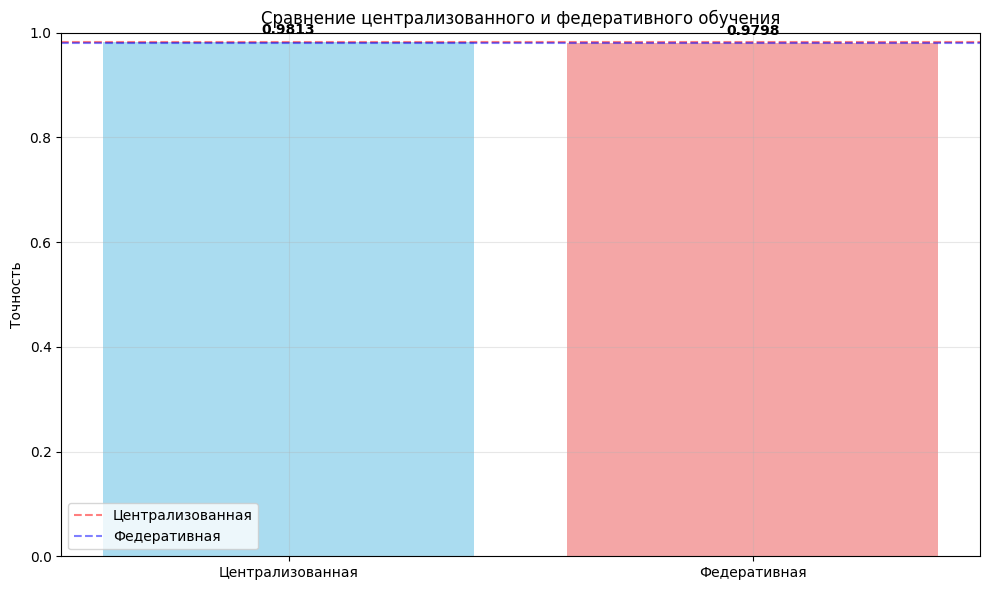

In [ ]:
def visualize_predictions_comparison(federated_model, centralized_model):
    sample_indices = np.random.choice(len(x_test), 8, replace=False)

    fed_predictions = federated_model.predict(x_test[sample_indices], verbose=0)
    fed_classes = np.argmax(fed_predictions, axis=1)
    fed_confidences = np.max(fed_predictions, axis=1)

    cent_predictions = centralized_model.predict(x_test[sample_indices], verbose=0)
    cent_classes = np.argmax(cent_predictions, axis=1)
    cent_confidences = np.max(cent_predictions, axis=1)

    fig, axes = plt.subplots(4, 4, figsize=(15, 12))

    for i, idx in enumerate(sample_indices):
        row = i * 2

        ax1 = axes[row, 0]
        ax1.imshow(x_test[idx].squeeze(), cmap='gray')
        fed_correct = fed_classes[i] == y_test[idx]
        color1 = 'green' if fed_correct else 'red'
        ax1.set_title(f'Федеративная\nPred: {fed_classes[i]} (conf: {fed_confidences[i]:.2f})',
                     color=color1, fontsize=10)
        ax1.axis('off')

        ax2 = axes[row, 1]
        ax2.imshow(x_test[idx].squeeze(), cmap='gray')
        cent_correct = cent_classes[i] == y_test[idx]
        color2 = 'green' if cent_correct else 'red'
        ax2.set_title(f'Централизованная\nPred: {cent_classes[i]} (conf: {cent_confidences[i]:.2f})',
                     color=color2, fontsize=10)
        ax2.axis('off')

        axes[row+1, 0].axis('off')
        axes[row+1, 1].axis('off')
        axes[row+1, 0].text(0.5, 0.5, f'True: {y_test[idx]}',
                           ha='center', va='center', fontsize=12, fontweight='bold')

    plt.suptitle('Сравнение предсказаний моделей', fontsize=16)
    plt.tight_layout()
    plt.show()

test_accuracy = start_complete_federated_system(8085)